In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join('..')))

# 1. Load Data

In this section, we will load the dataset from the feature engineering notebook, which contains important features relevant to our phishing detection analysis. This dataset has been pre-processed to include key attributes that will aid in identifying malicious URLs.

In [15]:
phish = pd.read_csv("../data/feature_engineered_data_pwdh.csv")
phish.sample(10)

,type,domain_age,domain_status,shortening_service,file_extension,domain_entropy,redirects,subdomains_count,digits_count,queries_count,special_characters_count,suspicious_query,is_common_tld,domain_length,url_length,is_https,sensitive_words
93146,2,0,0,0,0,2.750000,0,0,15,0,0,0,1,8,58,0,0
23727,0,10267,2,0,6,2.000000,0,0,12,0,17,0,1,4,99,1,0
117579,0,7838,2,0,0,2.584963,0,0,10,0,0,0,1,6,47,1,0
75043,1,0,0,0,5,2.725481,0,0,2,3,5,0,0,9,68,0,0
44625,1,5696,2,0,5,3.321928,0,0,10,4,10,0,1,10,92,0,0
139029,2,7536,2,0,5,2.321928,0,0,1,0,0,0,1,5,22,0,0
29609,0,6880,2,1,0,3.321928,0,0,12,6,15,0,0,10,130,1,0
44471,0,11179,2,0,5,2.584963,0,1,3,0,0,0,1,6,32,1,0
1921,0,9017,2,0,0,2.521641,0,0,0,0,1,0,1,7,29,1,0
147419,2,12311,2,0,0,2.000000,0,0,2,0,0,0,1,4,31,0,0


# 2. Analyze Data

In this section, we will conduct a comprehensive analysis of the dataset to uncover insights that can enhance our understanding of phishing detection.


### 2.1 Class Overview
In this section, we will examine the class distribution of the data as outlined in the feature engineering notebook. The following pie chart illustrates the distribution of different URL types within the dataset. 

The 'benign' class contains the most data, followed by the 'defacement', 'phishing', and 'malware' types. This visual representation will provide insights into the prevalence of each class, helping us understand the dataset's composition and the potential challenges in detecting malicious URLs.

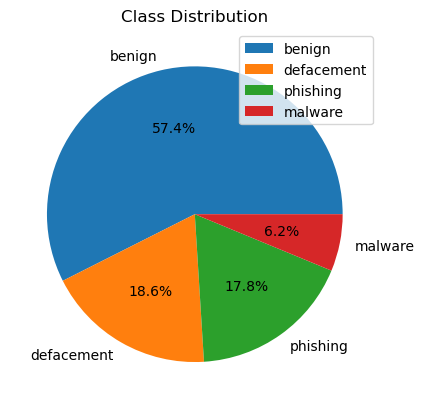

In [16]:
classes = ['benign', 'defacement', 'phishing', 'malware']
plt.pie(phish['type'].value_counts(), labels=classes, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.legend()
plt.show()

### 2.2 Domain Mean Entropy Distribution
Entropy can help detect malicious URLs by setting thresholds based on the entropies of legitimate URLs. We calculate the entropy of domain names, using the Shannon entropy formula. Malicous URLs have higher entropy.

$$H(X) = -\sum_{i=1}^{n} p(x_i) \log_b p(x_i)$$

Where:
- $ H(X) $ is the Shannon entropy.
- $ n $ is the number of possible outcomes.
- $ p(x_i) $ is the probability of outcome $ x_i $.
- $ \log_b $ is the logarithm to the base $ b $. Common choices for $ b $ are:
  - $ b = 2 $ for measuring entropy in bits.
  - $ b = e $ for measuring entropy in nats.
  - $ b = 10 $ for measuring entropy in dits.

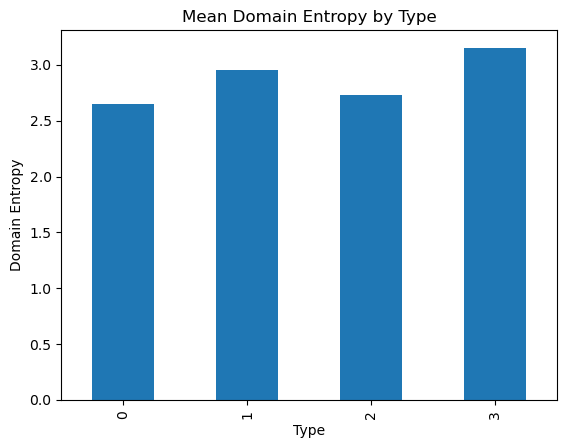

In [17]:
entropy_mean_by_type = phish.groupby('type')['domain_entropy'].mean()
ax = entropy_mean_by_type.plot(kind='bar')
ax.set(xlabel='Type', ylabel='Domain Entropy')
ax.set_title('Mean Domain Entropy by Type')
plt.show()

### 2.3 Mean Domain Age
In the context of phishing detection, the age of a domain can be a significant indicator of its legitimacy. Most malicious URLs tend to have lower domain ages, as attackers often register new domains to carry out their phishing activities. 

To illustrate this relationship, we will present a bar chart comparing the mean domain age of legitimate and malicious URLs.


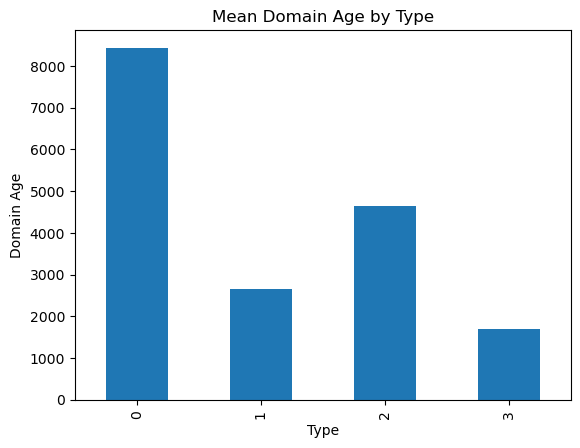

In [18]:
domain_age_mean_by_type = phish.groupby('type')['domain_age'].mean()
ax = domain_age_mean_by_type.plot(kind='bar')
ax.set(xlabel='Type', ylabel='Domain Age')
ax.set_title('Mean Domain Age by Type')
plt.show()

### 2.4 Feature Analysis by Type
The following mean bar charts illustrate several important features that can aid in phishing detection, categorized by URL type. Key features analyzed include:

- **Sensitive Words**: The presence of sensitive words in URLs, with the 'phishing' type exhibiting the highest frequency.
- **URL Length**: The length of the URL, which can be a critical factor in identifying potentially malicious links.
- **Special Characters Count**: The count of special characters in the URL, where the 'defacement' type tends to have a higher occurrence.
- **Queries Count**: The number of queries present in the URL, which can also provide insights into the nature of the URL.

These visual representations will help to highlight the differences in these features across various URL types, enhancing our understanding of the characteristics that distinguish legitimate URLs from malicious ones.


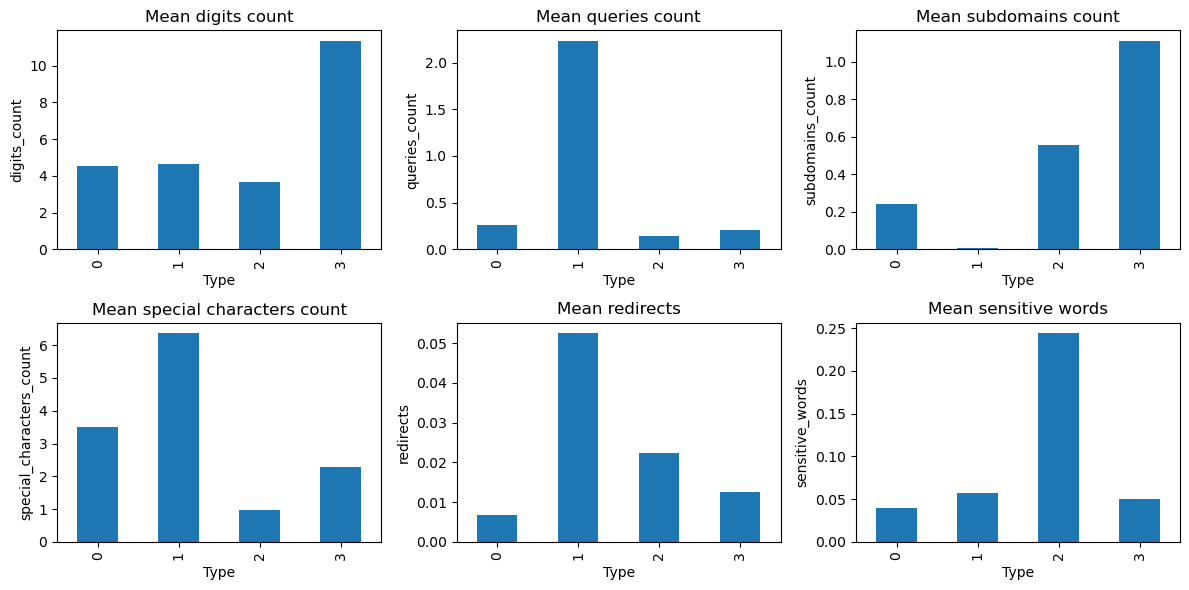

In [19]:
mean_columns = ['digits_count', 'special_characters_count','queries_count','redirects', 'subdomains_count', 'sensitive_words']
fig_rows = len(mean_columns)//2
fig, axs = plt.subplots(2,fig_rows, figsize=(12, fig_rows*2))

for i, col in enumerate(mean_columns):
    ax = axs[ i%2,i//2,]
    ax = phish.groupby('type')[col].mean().plot(kind='bar', ax=ax)
    ax.set(xlabel='Type', ylabel=col)
    ax.set_title(f'Mean {' '.join(col.split("_"))}')

plt.tight_layout()
plt.show()

# 3. Model Training

In this section, we will focus on training our phishing detection model using various classifiers. We will implement **Random Forest Classifier** and **XGBoost Classifier** algorithms:

We will evaluate the performance of each classifier using appropriate metrics and select the best-performing model for our phishing detection task. 


In [20]:
from sklearn.model_selection import train_test_split
X= phish.drop('type', axis=1)
y = phish['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train

,domain_age,domain_status,shortening_service,file_extension,domain_entropy,redirects,subdomains_count,digits_count,queries_count,special_characters_count,suspicious_query,is_common_tld,domain_length,url_length,is_https,sensitive_words
2863,8869,2,1,0,2.503258,0,1,0,0,3,0,1,9,61,0,0
94720,5301,2,0,0,2.921928,0,0,0,0,0,0,0,10,17,1,0
97835,7706,2,1,5,3.093069,0,0,5,0,14,0,1,14,121,1,0
137833,7962,0,0,5,2.000000,0,2,0,0,0,0,0,4,36,0,0
105922,11146,2,0,0,2.251629,0,0,6,0,4,0,1,6,55,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121683,0,0,1,0,2.251629,0,0,0,0,3,0,0,6,53,0,0
17534,7348,2,0,0,3.378783,0,0,0,0,2,0,1,14,35,1,0
20727,7821,2,1,0,1.921928,0,1,0,0,1,0,1,5,36,1,0
125678,2461,2,1,5,3.239098,0,0,1,1,1,0,0,18,55,0,0


In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

def experiment(classifier):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(
        f"Accuracy with {classifier.__class__.__name__}: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report with", classifier.__class__.__name__)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

### 3.1 Random Forest Classifier
 A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Accuracy with RandomForestClassifier: 0.9280
Classification Report with RandomForestClassifier
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     18278
           1       0.93      0.94      0.94      5942
           2       0.89      0.76      0.82      5628
           3       0.99      0.90      0.94      2011

    accuracy                           0.93     31859
   macro avg       0.94      0.90      0.91     31859
weighted avg       0.93      0.93      0.93     31859



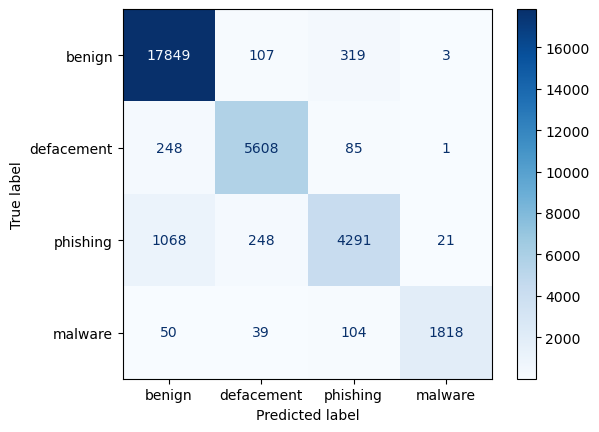

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(
    class_weight="balanced", random_state=42, n_estimators=200)

experiment(rf_classifier)

### 3.2 XGBoost Classifier 
Works by building an ensemble of decision trees sequentially where each new tree corrects the errors made by the previous one. It uses advanced optimization techniques and regularization methods that reduce overfitting and improve model performance.

Accuracy with XGBClassifier: 0.9317
Classification Report with XGBClassifier
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     18278
           1       0.94      0.96      0.95      5942
           2       0.87      0.80      0.83      5628
           3       0.98      0.92      0.95      2011

    accuracy                           0.93     31859
   macro avg       0.93      0.91      0.92     31859
weighted avg       0.93      0.93      0.93     31859



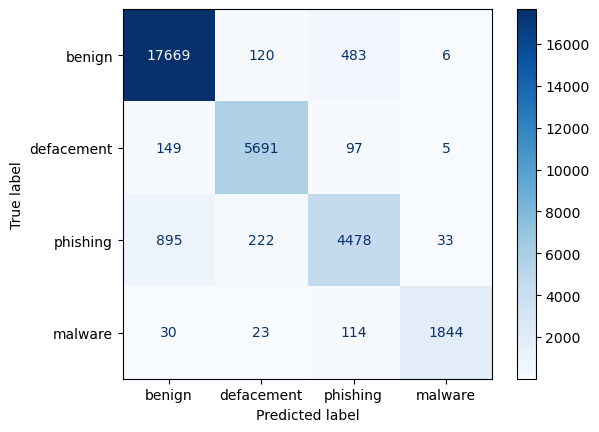

In [23]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(
    max_depth=50, random_state=42, n_estimators=200, objective='binary:logistic')

experiment(xgb_classifier)

# Model Selection

In our analysis, we observed that there is not much difference in performance between the Random Forest Classifier and the XGBoost Classifier. The Random Forest Classifier achieved an accuracy of **0.9267**, while the XGBoost Classifier slightly outperformed it with an accuracy of **0.9298**.

However, when evaluating recall, the XGBoost Classifier demonstrated a better performance for phishing detection, with a recall of **0.79** compared to the Random Forest's recall of **0.76**. Recall is a critical metric in phishing detection, as it measures the model's ability to correctly identify malicious URLs.

Despite the marginally higher accuracy of the XGBoost Classifier, we have decided to select and save the Random Forest Classifier for deployment. This decision is based on its robust performance and interpretability, making it a suitable choice for our phishing detection application.


In [24]:
import pickle

pickle.dump(rf_classifier, open(f'../reports/phishing_classifier.pkl', 'wb'))


##